In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 12-11-51.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 12-11-51_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_03.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752192170.138998 23254869 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752192170.147287 23255921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752192170.153858 23255916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752192180.635004 23255925 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 11937
Frames with at least 1 hand detected: 9814
Detection rate: 82.21%


In [59]:
df = pd.read_csv("hand_landmarks_03.csv")

print("Shape:", df.shape)
df

Shape: (343623, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,0.632154,0.651616,-3.382111e-07,1
1,0,0.000000,Left,1,0.572682,0.577591,-1.236181e-02,1
2,0,0.000000,Left,2,0.554300,0.476221,-1.209198e-02,1
3,0,0.000000,Left,3,0.565352,0.402458,-7.012891e-03,1
4,0,0.000000,Left,4,0.578871,0.371133,-5.678039e-04,1
...,...,...,...,...,...,...,...,...
343618,11936,198.933333,Right,16,NaN,NaN,NaN,0
343619,11936,198.933333,Right,17,NaN,NaN,NaN,0
343620,11936,198.933333,Right,18,NaN,NaN,NaN,0
343621,11936,198.933333,Right,19,NaN,NaN,NaN,0


In [61]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [63]:
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000000,Left,1,0.632154,0.572682,0.554300,0.565352,0.578871,0.629650,...,0.014487,0.017245,0.004088,0.014201,0.018059,0.016626,0.015939,0.020735,0.023521,0.024626
1,1,0.016667,Left,1,0.634984,0.573342,0.551887,0.558060,0.565441,0.630102,...,0.031050,0.038552,0.012934,0.026149,0.031315,0.031765,0.027482,0.034016,0.036667,0.038232
2,2,0.033333,Left,1,0.635687,0.576788,0.554251,0.552503,0.550734,0.630444,...,0.029312,0.036213,0.009506,0.024777,0.030478,0.029847,0.024740,0.032229,0.034794,0.035395
3,3,0.050000,Left,1,0.636115,0.577830,0.555177,0.550796,0.546093,0.631240,...,0.022047,0.028407,0.004740,0.018497,0.024465,0.024482,0.019227,0.025776,0.028674,0.029866
4,4,0.066667,Left,1,0.634079,0.576171,0.552125,0.546497,0.542414,0.630722,...,0.027507,0.034815,0.006829,0.022877,0.029821,0.030118,0.022071,0.030301,0.033877,0.035309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11286,11487,191.450000,Left,1,0.603965,0.591360,0.591587,0.592993,0.592038,0.619900,...,0.046104,0.046826,0.030595,0.045168,0.048711,0.048778,0.034912,0.045879,0.051555,0.054743
11287,11488,191.466667,Left,1,0.606821,0.594925,0.596536,0.600242,0.600537,0.614702,...,0.022701,0.023319,0.015488,0.022328,0.024756,0.025582,0.017841,0.023705,0.028252,0.031554
11288,11489,191.483333,Left,1,0.606306,0.589227,0.589428,0.592175,0.592123,0.615608,...,0.032487,0.033218,0.023759,0.033979,0.036511,0.036609,0.030488,0.037655,0.041684,0.044186
11289,11490,191.500000,Left,1,0.606951,0.594739,0.596021,0.597798,0.596010,0.619457,...,0.030659,0.031935,0.019919,0.028831,0.032263,0.033535,0.022704,0.029244,0.033882,0.037216


In [65]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000,Left,1,0.632154,0.572682,0.554300,0.565352,0.578871,0.629650,...,0.014487,0.017245,0.004088,0.014201,0.018059,0.016626,0.015939,0.020735,0.023521,0.024626
1,1,0.017,Left,1,0.634984,0.573342,0.551887,0.558060,0.565441,0.630102,...,0.031050,0.038552,0.012934,0.026149,0.031315,0.031765,0.027482,0.034016,0.036667,0.038232
2,2,0.033,Left,1,0.635687,0.576788,0.554251,0.552503,0.550734,0.630444,...,0.029312,0.036213,0.009506,0.024777,0.030478,0.029847,0.024740,0.032229,0.034794,0.035395
3,3,0.050,Left,1,0.636115,0.577830,0.555177,0.550796,0.546093,0.631240,...,0.022047,0.028407,0.004740,0.018497,0.024465,0.024482,0.019227,0.025776,0.028674,0.029866
4,4,0.067,Left,1,0.634079,0.576171,0.552125,0.546497,0.542414,0.630722,...,0.027507,0.034815,0.006829,0.022877,0.029821,0.030118,0.022071,0.030301,0.033877,0.035309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11286,11487,191.450,Left,1,0.603965,0.591360,0.591587,0.592993,0.592038,0.619900,...,0.046104,0.046826,0.030595,0.045168,0.048711,0.048778,0.034912,0.045879,0.051555,0.054743
11287,11488,191.467,Left,1,0.606821,0.594925,0.596536,0.600242,0.600537,0.614702,...,0.022701,0.023319,0.015488,0.022328,0.024756,0.025582,0.017841,0.023705,0.028252,0.031554
11288,11489,191.483,Left,1,0.606306,0.589227,0.589428,0.592175,0.592123,0.615608,...,0.032487,0.033218,0.023759,0.033979,0.036511,0.036609,0.030488,0.037655,0.041684,0.044186
11289,11490,191.500,Left,1,0.606951,0.594739,0.596021,0.597798,0.596010,0.619457,...,0.030659,0.031935,0.019919,0.028831,0.032263,0.033535,0.022704,0.029244,0.033882,0.037216


In [67]:
df2 = pd.read_csv("hand_lable_03.csv")

print("Shape:", df.shape)
df2

Shape: (343623, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,lift,NaN,START,28.967,D:/Data Science/UOB/DS_project/Full Study/03/2...,1738,NaN,NaN
1,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,lift,NaN,STOP,30.600,D:/Data Science/UOB/DS_project/Full Study/03/2...,1836,NaN,NaN
2,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,hold,NaN,START,30.617,D:/Data Science/UOB/DS_project/Full Study/03/2...,1837,NaN,NaN
3,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,hold,NaN,STOP,35.350,D:/Data Science/UOB/DS_project/Full Study/03/2...,2121,NaN,NaN
4,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,press,NaN,START,35.367,D:/Data Science/UOB/DS_project/Full Study/03/2...,2122,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,hold,NaN,STOP,189.617,D:/Data Science/UOB/DS_project/Full Study/03/2...,11377,NaN,NaN
190,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,place,NaN,START,189.633,D:/Data Science/UOB/DS_project/Full Study/03/2...,11378,NaN,NaN
191,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,place,NaN,STOP,190.800,D:/Data Science/UOB/DS_project/Full Study/03/2...,11448,NaN,NaN
192,3,2025-07-07 20:22:06.716,NaN,169.966,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,198.95,60.0,1.0,other,NaN,START,190.817,D:/Data Science/UOB/DS_project/Full Study/03/2...,11449,NaN,NaN


In [69]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,lift,28.967,30.600,1738,1836
1,hold,30.617,35.350,1837,2121
2,press,35.367,35.750,2122,2145
3,hold,35.767,39.600,2146,2376
4,press,39.617,39.850,2377,2391
...,...,...,...,...,...
92,hold,187.700,188.033,11262,11282
93,press,188.050,188.317,11283,11299
94,hold,188.333,189.617,11300,11377
95,place,189.633,190.800,11378,11448


In [71]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_7119/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lift' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.632154,0.572682,0.554300,0.565352,0.578871,0.629650,...,0.017245,0.004088,0.014201,0.018059,0.016626,0.015939,0.020735,0.023521,0.024626,NaN
1,1,0.017,Left,1,0.634984,0.573342,0.551887,0.558060,0.565441,0.630102,...,0.038552,0.012934,0.026149,0.031315,0.031765,0.027482,0.034016,0.036667,0.038232,NaN
2,2,0.033,Left,1,0.635687,0.576788,0.554251,0.552503,0.550734,0.630444,...,0.036213,0.009506,0.024777,0.030478,0.029847,0.024740,0.032229,0.034794,0.035395,NaN
3,3,0.050,Left,1,0.636115,0.577830,0.555177,0.550796,0.546093,0.631240,...,0.028407,0.004740,0.018497,0.024465,0.024482,0.019227,0.025776,0.028674,0.029866,NaN
4,4,0.067,Left,1,0.634079,0.576171,0.552125,0.546497,0.542414,0.630722,...,0.034815,0.006829,0.022877,0.029821,0.030118,0.022071,0.030301,0.033877,0.035309,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11286,11487,191.450,Left,1,0.603965,0.591360,0.591587,0.592993,0.592038,0.619900,...,0.046826,0.030595,0.045168,0.048711,0.048778,0.034912,0.045879,0.051555,0.054743,other
11287,11488,191.467,Left,1,0.606821,0.594925,0.596536,0.600242,0.600537,0.614702,...,0.023319,0.015488,0.022328,0.024756,0.025582,0.017841,0.023705,0.028252,0.031554,other
11288,11489,191.483,Left,1,0.606306,0.589227,0.589428,0.592175,0.592123,0.615608,...,0.033218,0.023759,0.033979,0.036511,0.036609,0.030488,0.037655,0.041684,0.044186,other
11289,11490,191.500,Left,1,0.606951,0.594739,0.596021,0.597798,0.596010,0.619457,...,0.031935,0.019919,0.028831,0.032263,0.033535,0.022704,0.029244,0.033882,0.037216,other


In [73]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
hold      4419
rotate    2603
adjust    1506
NaN       1070
other      474
press      464
place      408
lift       347
Name: count, dtype: int64


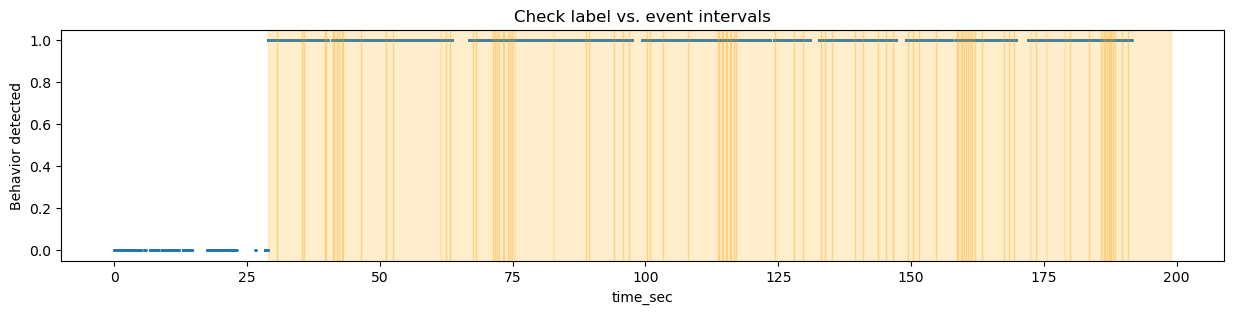

In [75]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [84]:
df_wide[(df_wide['time_sec'] <= 28.967)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
1067,28.933,NaN
1068,28.950,NaN
1069,28.950,NaN
1070,28.967,lift


In [86]:
df_wide[(df_wide['time_sec'] <= 117.050)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
6791,116.983,press
6792,117.000,press
6793,117.017,press
6794,117.033,press


In [88]:
df_wide[(df_wide['time_sec'] <= 158.917)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
9198,158.850,press
9199,158.867,press
9200,158.883,press
9201,158.900,press


In [91]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1070,1738,28.967,Left,1,0.724268,0.688855,0.659487,0.633987,0.609060,0.697946,...,0.002376,0.013906,0.016673,0.013394,0.009493,0.015064,0.017641,0.019082,0.019844,lift
1071,1738,28.967,Right,1,0.436104,0.477345,0.506584,0.527328,0.540993,0.479883,...,0.051451,0.037732,0.052402,0.053578,0.053163,0.048917,0.059862,0.062527,0.064801,lift
1072,1739,28.983,Left,1,0.723179,0.687710,0.659081,0.634161,0.609567,0.698551,...,-0.006201,0.009590,0.009969,0.006497,0.002344,0.012691,0.012145,0.012604,0.013171,lift
1073,1739,28.983,Right,1,0.434649,0.475487,0.505389,0.527338,0.541052,0.479931,...,0.048697,0.036628,0.051339,0.052017,0.051046,0.048094,0.058843,0.061256,0.063216,lift
1074,1740,29.000,Left,1,0.725063,0.689514,0.660109,0.634101,0.608724,0.707436,...,-0.001570,0.014576,0.017934,0.014009,0.008742,0.018482,0.020731,0.021419,0.021353,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11286,11487,191.450,Left,1,0.603965,0.591360,0.591587,0.592993,0.592038,0.619900,...,0.046826,0.030595,0.045168,0.048711,0.048778,0.034912,0.045879,0.051555,0.054743,other
11287,11488,191.467,Left,1,0.606821,0.594925,0.596536,0.600242,0.600537,0.614702,...,0.023319,0.015488,0.022328,0.024756,0.025582,0.017841,0.023705,0.028252,0.031554,other
11288,11489,191.483,Left,1,0.606306,0.589227,0.589428,0.592175,0.592123,0.615608,...,0.033218,0.023759,0.033979,0.036511,0.036609,0.030488,0.037655,0.041684,0.044186,other
11289,11490,191.500,Left,1,0.606951,0.594739,0.596021,0.597798,0.596010,0.619457,...,0.031935,0.019919,0.028831,0.032263,0.033535,0.022704,0.029244,0.033882,0.037216,other


In [95]:
df_wide['dataset_id'] = '03'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_7119/2500585271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '03'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1070,03,1738,28.967,Left,1,0.724268,0.688855,0.659487,0.633987,0.609060,...,0.002376,0.013906,0.016673,0.013394,0.009493,0.015064,0.017641,0.019082,0.019844,lift
1071,03,1738,28.967,Right,1,0.436104,0.477345,0.506584,0.527328,0.540993,...,0.051451,0.037732,0.052402,0.053578,0.053163,0.048917,0.059862,0.062527,0.064801,lift
1072,03,1739,28.983,Left,1,0.723179,0.687710,0.659081,0.634161,0.609567,...,-0.006201,0.009590,0.009969,0.006497,0.002344,0.012691,0.012145,0.012604,0.013171,lift
1073,03,1739,28.983,Right,1,0.434649,0.475487,0.505389,0.527338,0.541052,...,0.048697,0.036628,0.051339,0.052017,0.051046,0.048094,0.058843,0.061256,0.063216,lift
1074,03,1740,29.000,Left,1,0.725063,0.689514,0.660109,0.634101,0.608724,...,-0.001570,0.014576,0.017934,0.014009,0.008742,0.018482,0.020731,0.021419,0.021353,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11286,03,11487,191.450,Left,1,0.603965,0.591360,0.591587,0.592993,0.592038,...,0.046826,0.030595,0.045168,0.048711,0.048778,0.034912,0.045879,0.051555,0.054743,other
11287,03,11488,191.467,Left,1,0.606821,0.594925,0.596536,0.600242,0.600537,...,0.023319,0.015488,0.022328,0.024756,0.025582,0.017841,0.023705,0.028252,0.031554,other
11288,03,11489,191.483,Left,1,0.606306,0.589227,0.589428,0.592175,0.592123,...,0.033218,0.023759,0.033979,0.036511,0.036609,0.030488,0.037655,0.041684,0.044186,other
11289,03,11490,191.500,Left,1,0.606951,0.594739,0.596021,0.597798,0.596010,...,0.031935,0.019919,0.028831,0.032263,0.033535,0.022704,0.029244,0.033882,0.037216,other


In [98]:
df_wide.to_csv("handlandmark_wide_03.csv", index=False)